In [1]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import colors as colors_lib
import random
import pickle
import numpy as np
from typing import List
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from typing import List, Dict

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
x,y = mnist.data, mnist.target
x,y = shuffle(x,y)

In [4]:
def show_some_images(images, n = 3, dims = 1):
  
  for index, image in enumerate(images[:n]):
    if dims == 1:
        plt.imshow(image.reshape(28,28),cmap='gray')
    else:
        plt.imshow(image.reshape(28,28,3))
    plt.show()

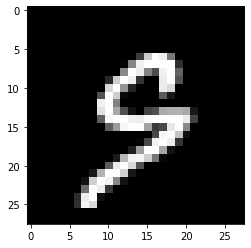

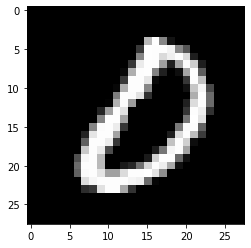

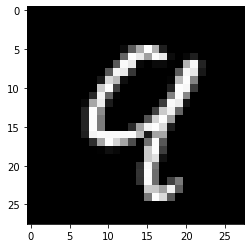

In [5]:
show_some_images(x)

In [6]:
np.save("mnist_x.npy", x)
np.save("mnist_y.npy", y)
x_3d = np.stack([x,x,x])
x_3d = np.swapaxes(x_3d, 0, 2)
x_3d = np.swapaxes(x_3d, 0, 1)
x_3d /= 255.

In [7]:
x_3d.shape

(70000, 784, 3)

In [14]:
def colorize(x, colors: List[str], threshold: float):
    
    x_copy = x.copy().reshape(x.shape[0], 28, 28, x.shape[-1])
    x_colored = x_copy.copy()

    color_strings = []
    
    for i,img in enumerate(x_colored):
        color_str = random.choice(colors)
        color_background_str = random.choice([x for x in colors if x != color_str])
        #print(color_str, color_background_str)
        
        color = np.array(colors_lib.to_rgb(color_str))
        color_background = np.array(colors_lib.to_rgb(color_background_str))
        color_strings.append((color_str, color))

        color_mask = np.zeros_like(x_colored[0])
        color_mask[:, :] = color
        idx = (img > threshold)[:,:,0]
        x_colored[i][idx] = color*(1 - 0.6*x_colored[i][idx])

        #idx_background = (img < threshold)[:,:,0]
        #x_colored[i][idx_background] = color_background*(1 - 0.6*x_colored[i][idx_background])
    return x_colored, color_strings

In [26]:
colors = np.random.rand(25) # ["blue", "red", "green", "yellow", "cyan", "orange", "purple", "lime"]
colors = list(colors_lib.CSS4_COLORS.keys())
print(colors[:10])
x_colored, color_strings = colorize(x_3d[:], colors = colors, threshold = 0.1)

['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue']


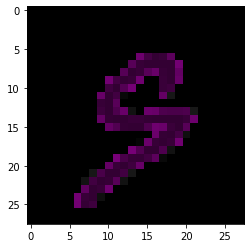

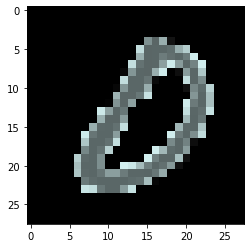

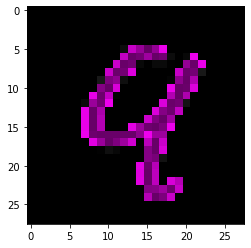

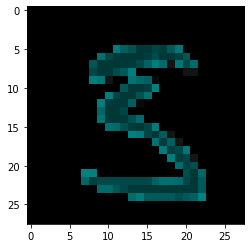

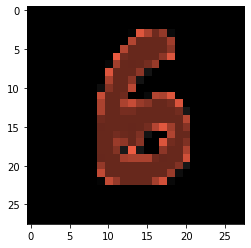

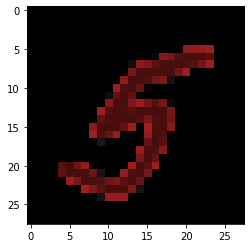

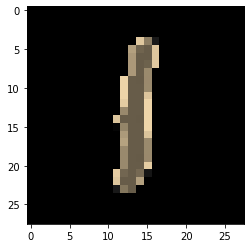

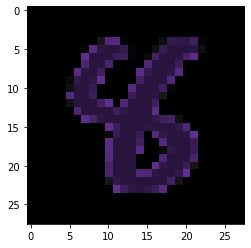

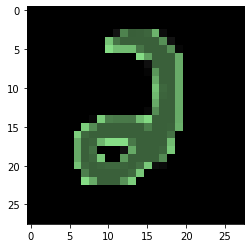

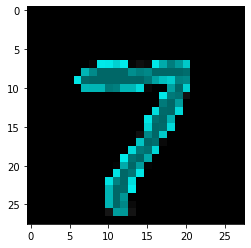

In [27]:
show_some_images(x_colored,dims=10, n = 10)

In [17]:
colored_mnist = []
for x,y,c in zip(x_colored, y, color_strings):
    
    colored_mnist.append({"x": x, "y": y, "color": c})

#with open("mnist.colored.dict.pickle", "wb") as f:
#    pickle.dump(colored_mnist, f)

In [18]:
""" 
model = MLPClassifier(verbose = True)
x_colored_flat = x_colored.reshape(x_colored.shape[0], 28*28*3)
model.fit(x_colored_flat[:60000], y[:60000])
print(model.score(x_colored_flat[60000:], y[60000:]))
"""

' \nmodel = MLPClassifier(verbose = True)\nx_colored_flat = x_colored.reshape(x_colored.shape[0], 28*28*3)\nmodel.fit(x_colored_flat[:60000], y[:60000])\nprint(model.score(x_colored_flat[60000:], y[60000:]))\n'

In [19]:
class Dataset(torch.utils.data.Dataset):
    """Simple torch dataset class"""

    def __init__(self, data: List[Dict], device = "cpu"):

        self.data = data
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        with torch.no_grad():
            
            x,y,color = self.data[index]["x"], self.data[index]["y"], self.data[index]["color"]

            return torch.tensor(x.reshape(-1)).float(), int(y), color

In [20]:
train, dev = colored_mnist[:60000], colored_mnist[60000:]
train_dataset, dev_dataset = Dataset(train), Dataset(dev)

In [21]:
class MLP(pl.LightningModule):

    def __init__(self, train_dataset: Dataset, dev_dataset: Dataset, batch_size, device: str):
        
        super().__init__()
        
        self.device = device
        self.train_dataset = train_dataset
        self.dev_dataset = dev_dataset

        self.train_gen = torch.utils.data.DataLoader(self.train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        self.dev_gen = torch.utils.data.DataLoader(self.dev_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        self.acc = None
        
        layers = [28*28*3, 256, 10]
        net = []
        
        for i, (l1,l2) in enumerate(zip(layers, layers[1:])):
            
            net.append(nn.Linear(l1,l2))
            if i != len(layers) - 2:
             net.append(nn.ReLU())
            
        self.net = nn.Sequential(*net)
        self.loss = torch.nn.CrossEntropyLoss()
        
    def forward(self, x):
        
        outputs = self.net(x)
        return outputs
    
    def training_step(self, batch, batch_nb):
        
        x,y,c = batch
        logits = self.forward(x)
        
        loss = self.loss(logits, y)
        correct = logits.argmax(axis=1).int() == y.int()
        acc = torch.sum(correct).float() / len(y)

        return {'loss': loss, 'val_acc': acc}
    
    def validation_step(self, batch, batch_nb):
        
        x,y,c = batch
        
        logits = self.forward(x)
        
        loss = self.loss(logits, y)
        correct = logits.argmax(axis=1).int() == y.int()
        acc = torch.sum(correct).float() / len(y)

        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        print("Loss is {}".format(avg_loss))
        print("Accuracy is {}".format(avg_acc))
        self.acc = avg_acc
        return {'avg_val_loss': avg_loss}
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.005, momentum=0.9)
        #return torch.optim.RMSprop(self.parameters(), lr = (1e-3)/2)
        #return torch.optim.Adam(self.parameters(), lr = 1e-3)
    
    @pl.data_loader
    def train_dataloader(self):
        return self.train_gen

    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        # can also return a list of val dataloaders
        return self.dev_gen

In [22]:
mlp = MLP(train_dataset, dev_dataset, batch_size = 32, device = "cpu")

In [23]:
trainer = Trainer(max_nb_epochs=10,min_nb_epochs=5, gpus = 1)
trainer.fit(mlp)

Epoch 1:   2%|▏         | 33/2188 [00:00<00:27, 78.77batch/s, batch_nb=32, gpu=0, loss=2.277, v_nb=19]

Loss is 2.3075995445251465
Accuracy is 0.08749999850988388


Epoch 1: 100%|██████████| 2188/2188 [00:07<00:00, 510.69batch/s, batch_nb=1874, gpu=0, loss=0.443, v_nb=19]
                                                                 /home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:250: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
Epoch 2:   2%|▏         | 47/2188 [00:00<00:04, 510.69batch/s, batch_nb=46, gpu=0, loss=0.431, v_nb=19]    

Loss is 0.43242543935775757
Accuracy is 0.8837859034538269


Epoch 3:   2%|▏         | 51/2188 [00:00<00:04, 516.94batch/s, batch_nb=50, gpu=0, loss=0.321, v_nb=19]    

Loss is 0.3619895577430725
Accuracy is 0.9000598788261414


Epoch 4:   2%|▏         | 50/2188 [00:00<00:04, 514.50batch/s, batch_nb=49, gpu=0, loss=0.259, v_nb=19]    

Loss is 0.2945007085800171
Accuracy is 0.9202276468276978


Epoch 5:   2%|▏         | 46/2188 [00:00<00:04, 496.94batch/s, batch_nb=45, gpu=0, loss=0.229, v_nb=19]    

Loss is 0.2600804567337036
Accuracy is 0.9287140369415283


Epoch 6:   2%|▏         | 47/2188 [00:00<00:04, 485.22batch/s, batch_nb=46, gpu=0, loss=0.188, v_nb=19]    

Loss is 0.2474595606327057
Accuracy is 0.9288138747215271


Epoch 7:   2%|▏         | 46/2188 [00:00<00:04, 505.94batch/s, batch_nb=45, gpu=0, loss=0.176, v_nb=19]    

Loss is 0.23088227212429047
Accuracy is 0.9339057207107544


Epoch 7: 100%|██████████| 2188/2188 [00:08<00:00, 456.88batch/s, batch_nb=1874, gpu=0, loss=0.169, v_nb=19]
                                                                 /home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:128: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: avg_val_loss
  RuntimeWarning)
Epoch 7: 100%|██████████| 2188/2188 [00:08<00:00, 264.53batch/s, batch_nb=1874, gpu=0, loss=0.169, v_nb=19]


Loss is 0.21535462141036987
Accuracy is 0.9397963285446167


1